In [1]:
# Loading necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Connect to the existing Data Warehouse
conn = sqlite3.connect("retail_dw.db")

In [10]:
# Roll-up: Total sales by country and quarter (calculated from month)
# Aggregate total sales by Country and Quarter
query_rollup = """
SELECT 
    c.Country, 
    strftime('%Y', f.InvoiceDate) AS Year,
    ((cast(strftime('%m', f.InvoiceDate) as integer)-1)/3 + 1) AS Quarter,
    SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
GROUP BY c.Country, Year, Quarter
ORDER BY TotalSales DESC;
"""
df_rollup = pd.read_sql_query(query_rollup, conn)
print(df_rollup.head())


          Country  Year  Quarter   TotalSales
0  United Kingdom  2011        4  2277796.140
1  United Kingdom  2011        3  1780845.843
2  United Kingdom  2011        2  1486043.441
3  United Kingdom  2011        1  1265044.280
4  United Kingdom  2010        4   498661.850


In [12]:
# Drill-down: Sales details for a specific country (e.g., United Kingdom) by month
query_drilldown = """
SELECT 
    c.Country,
    t.Year,
    t.Month,
    SUM(f.TotalSales) AS TotalSales
FROM SalesFact f
JOIN CustomerDim c 
    ON f.CustomerID = c.CustomerID
JOIN TimeDim t 
    ON DATE(f.InvoiceDate) = DATE(t.InvoiceDate)
WHERE c.Country = 'United Kingdom'
GROUP BY c.Country, t.Year, t.Month
ORDER BY t.Year, t.Month;
"""
df_drilldown = pd.read_sql_query(query_drilldown, conn)
print("\nDRILL-DOWN QUERY RESULT:")
print(df_drilldown.head())



DRILL-DOWN QUERY RESULT:
          Country  Year  Month  TotalSales
0  United Kingdom  2010     12  498661.850
1  United Kingdom  2011      1  442190.060
2  United Kingdom  2011      2  355655.630
3  United Kingdom  2011      3  467198.590
4  United Kingdom  2011      4  409559.141


In [48]:
# Enhanced category mapping with more keywords and categories
category_map = {
    'Electronics': ['battery', 'charger', 'usb', 'cable', 'phone', 'headphone', 'speaker', 
                   'adapter', 'mouse', 'keyboard', 'lamp', 'bulb', 'torch', 'projector'],
    'Home': ['cushion', 'mirror', 'hanger', 'tray', 'clock', 'light', 'vase', 'basket',
             'stool', 'box', 'storage', 'mat', 'doormat', 'letters', 'measure', 'ladder'],
    'Kitchen': ['plate', 'cup', 'bowl', 'knife', 'fork', 'spoon', 'teapot', 'kettle',
                'grater', 'whisk', 'apron', 'gloves', 'coaster', 'napkin'],
    'Stationery': ['pen', 'pencil', 'notebook', 'envelope', 'rubber', 'sharpener',
                   'tape', 'ruler', 'scissors', 'punch', 'folder', 'postcard'],
    'Toys': ['toy', 'doll', 'ball', 'game', 'puzzle', 'dominoes', 'balloons', 
             'blocks', 'figure', 'puppet'],
    'Decorations': ['decoration', 'garland', 'ornament', 'christmas', 'skull', 
                    'rose', 'candle', 'design', 'party', 'gift'],
    'Bags': ['bag', 'wallet', 'case', 'purse', 'holder', 'pouch', 'backpack'],
    'Clothing': ['sock', 'glove', 'hat', 'scarf', 'mittens', 'shawl', 'tie'],
    'Art': ['canvas', 'paint', 'frame', 'easel', 'palette', 'brush'],
    'Garden': ['plant', 'pot', 'watering', 'flower', 'gardening', 'shears']
}

# Improved categorization with multi-word matching
def auto_categorize(desc):
    if pd.isna(desc):
        return 'Uncategorized'
    
    desc = str(desc).lower()
    
    # Check for multi-word matches first
    if 'storage box' in desc: return 'Home'
    if 'gift wrap' in desc: return 'Decorations'
    if 'tape measure' in desc: return 'Home'
    if 'party balloons' in desc: return 'Decorations'
    
    # Then check single word matches
    for category, keywords in category_map.items():
        if any(f' {kw} ' in f' {desc} ' for kw in keywords):
            return category
            
    return 'Other'

# Re-categorize products
unique_products['Category'] = unique_products['Description'].apply(auto_categorize)

# Show improved results
print("\nImproved Category Distribution:")
print(unique_products['Category'].value_counts())

# Show sample recategorized items
recategorized = unique_products[
    (unique_products['Category'] != 'Other') & 
    (unique_products['Category'] != 'Uncategorized')
].sample(5)
print("\nSample Recategorized Products:")
print(recategorized[['Description', 'Category']].to_string(index=False))


Improved Category Distribution:
Other          2173
Decorations     581
Home            457
Bags            234
Kitchen         169
Garden           89
Stationery       87
Art              60
Toys             51
Electronics      38
Clothing         19
Name: Category, dtype: int64

Sample Recategorized Products:
                       Description    Category
 LIGHT DECORATION BATTERY OPERATED Electronics
   SET OF 4 ROSE BOTANICAL CANDLES Decorations
      RED TEA TOWEL CLASSIC DESIGN Decorations
CHOCOLATE 3 WICK MORRIS BOX CANDLE        Home
           TURQ ICE CREAM BUM BAG         Bags


In [51]:
# Existing category mapping
category_map = {
    'Electronics': ['battery', 'charger', 'usb', 'cable', 'phone', 'headphone', 'speaker', 
                   'adapter', 'mouse', 'keyboard', 'lamp', 'bulb', 'torch', 'projector'],
    'Home': ['cushion', 'mirror', 'hanger', 'tray', 'clock', 'light', 'vase', 'basket',
             'stool', 'box', 'storage', 'mat', 'doormat', 'letters', 'measure', 'ladder'],
    'Kitchen': ['plate', 'cup', 'bowl', 'knife', 'fork', 'spoon', 'teapot', 'kettle',
                'grater', 'whisk', 'apron', 'gloves', 'coaster', 'napkin'],
    'Stationery': ['pen', 'pencil', 'notebook', 'envelope', 'rubber', 'sharpener',
                   'tape', 'ruler', 'scissors', 'punch', 'folder', 'postcard'],
    'Toys': ['toy', 'doll', 'ball', 'game', 'puzzle', 'dominoes', 'balloons', 
             'blocks', 'figure', 'puppet'],
    'Decorations': ['decoration', 'garland', 'ornament', 'christmas', 'skull', 
                    'rose', 'candle', 'design', 'party', 'gift'],
    'Bags': ['bag', 'wallet', 'case', 'purse', 'holder', 'pouch', 'backpack'],
    'Clothing': ['sock', 'glove', 'hat', 'scarf', 'mittens', 'shawl', 'tie'],
    'Art': ['canvas', 'paint', 'frame', 'easel', 'palette', 'brush'],
    'Garden': ['plant', 'pot', 'watering', 'flower', 'gardening', 'shears']
}

with sqlite3.connect("retail_dw.db") as conn:
    # Check if Category column exists
    table_info = pd.read_sql("PRAGMA table_info(SalesFact);", conn)
    
    if 'Category' not in table_info['name'].values:
        print("Creating temporary categorized view...")
        # Build dynamic CASE statement
        case_parts = []
        for category, keywords in category_map.items():
            conditions = " OR ".join([f"Description LIKE '%{kw}%'" for kw in keywords])
            case_parts.append(f"WHEN {conditions} THEN '{category}'")
        
        case_stmt = "CASE\n" + "\n".join(case_parts) + "\nELSE 'Other' END AS Category"
        
        # Create temporary view (same connection)
        conn.execute(f"""
        CREATE TEMP VIEW IF NOT EXISTS categorized_sales AS
        SELECT *, {case_stmt}
        FROM SalesFact
        """)
        table = "categorized_sales"
    else:
        table = "SalesFact"
    
    # Query all categories (same connection)
    df_sales = pd.read_sql(f"""
    SELECT 
        Category,
        SUM(TotalSales) AS TotalSales,
        COUNT(*) AS TransactionCount
    FROM {table}
    GROUP BY Category
    ORDER BY TotalSales DESC
    """, conn)
    
    print("\nSALES BY CATEGORY:")
    print(df_sales.to_string(index=False, formatters={
        'TotalSales': '${:,.2f}'.format,
        'TransactionCount': '{:,}'.format
    }))
    
    # Electronics-specific query (same connection)
    df_electronics = pd.read_sql(f"""
    SELECT 
        Description,
        SUM(TotalSales) AS TotalSales
    FROM {table}
    WHERE Category = 'Electronics'
    GROUP BY Description
    ORDER BY TotalSales DESC
    LIMIT 5
    """, conn)
    
    print("\nTOP ELECTRONICS PRODUCTS:")
    print(df_electronics.to_string(index=False, formatters={
        'TotalSales': '${:,.2f}'.format
    }))

Creating temporary categorized view...

SALES BY CATEGORY:
   Category    TotalSales TransactionCount
      Other $3,077,678.89          139,990
       Home $1,948,628.19           67,919
Decorations $1,211,643.67           65,555
       Bags   $889,946.75           38,704
     Garden   $486,959.92           21,055
    Kitchen   $424,781.14           25,105
        Art   $235,369.23            8,148
   Clothing   $231,645.78            5,386
       Toys   $217,133.36           12,352
 Stationery   $166,512.17           12,540
Electronics    $21,108.80            1,130

TOP ELECTRONICS PRODUCTS:
                 Description TotalSales
        CAMOUFLAGE LED TORCH  $4,278.12
ANTIQUE SILVER BAUBLE LAMP    $3,489.70
              RETROSPOT LAMP  $2,962.65
    IVORY CAFE HANGING LAMP   $1,330.50
 MOUSE TOY WITH PINK T-SHIRT  $1,260.05


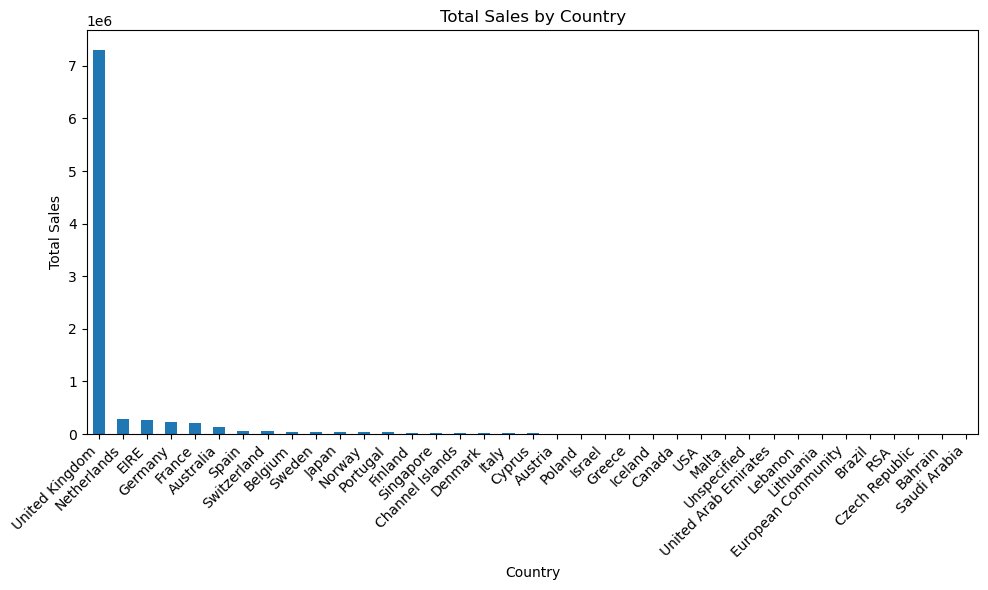

In [ ]:
# Visualization — Bar chart of roll-up result (Total Sales by Country)
plt.figure(figsize=(10, 6))
df_rollup.groupby("Country")["TotalSales"].sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Total Sales by Country")
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("sales_by_country.png")
plt.show()

# Close the connection
conn.close()

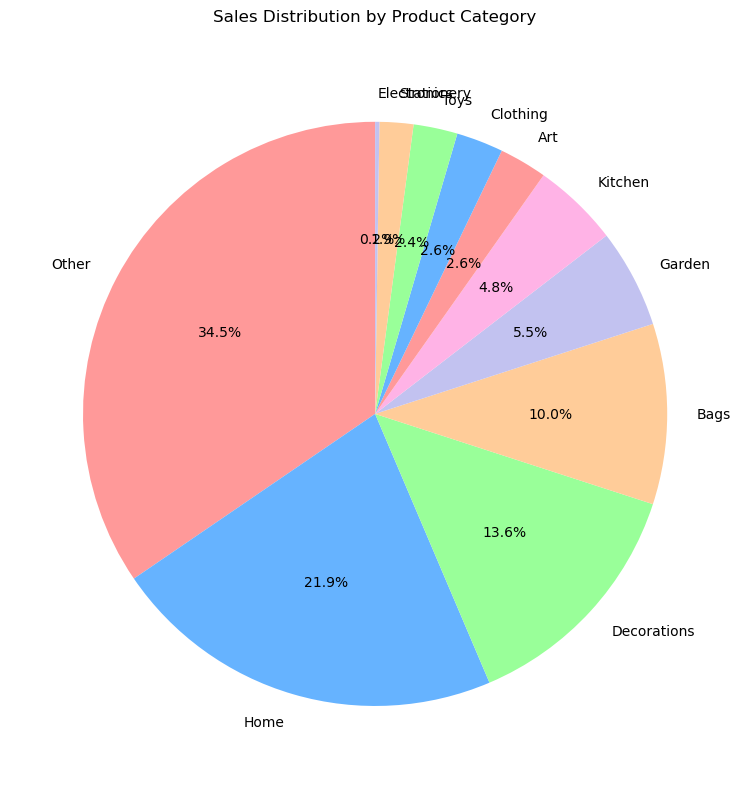

In [53]:
# Visualization — Pie chart of sales by product category
plt.figure(figsize=(10, 8))
category_sales = df_sales.groupby("Category")["TotalSales"].sum().sort_values(ascending=False)
category_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                   colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
plt.title('Sales Distribution by Product Category', pad=20)
plt.ylabel('')  # Remove y-axis label
plt.tight_layout()
plt.savefig("sales_by_category.png")
plt.show()
